In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from isaac.dataset import read_dataset, prepare_dataset, prepare_test_dataset
from isaac.utils import plot_confusion_matrix
from isaac.models import RNNModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS
from isaac.training import evaluate, training_loop

In [4]:
BATCH_SIZE = 128
EPOCHS = 50
TEST_SIZE = 0.2
NORMALISE_DATA = True

# MASS TRAINING (Humans achieve 46% +- 29%)

## Read dataset and preprocess it

In [5]:
all_trials = read_dataset("data/train_passive_trials.h5", first_n_trials=3500)
train_loader, val_loader, scaler = prepare_dataset(all_trials, MASS_CLASS_COLS, BATCH_SIZE, NORMALISE_DATA, TEST_SIZE)

100%|██████████| 3500/3500 [00:02<00:00, 1179.77it/s]


In [6]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [7]:
counts

array([926, 909, 965])

In [8]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.34464285714285714


## Define model, loss and optimizer

In [7]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
hidden_dim = 12  # hidden layer dimension
n_layers = 2     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.5

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train model and plot loss and accuracy

In [10]:
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS)

Train_loss (0.23)	 Train_acc (86.89)	 Val_acc (76.57): 100%|██████████| 50/50 [03:38<00:00,  4.39s/it]


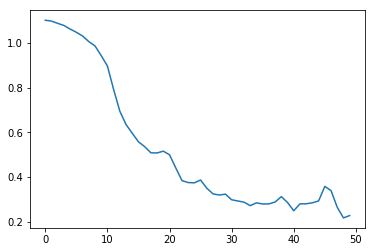

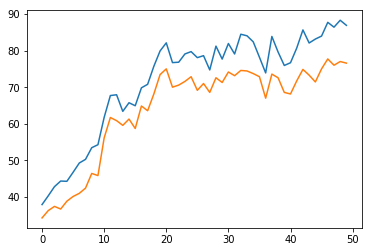

In [11]:
#batch 128, StandardScaler, last 1000, lr=0.0005
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [12]:
max(epoch_accuracies[1])

77.71428571428571

## Save model and scaler

In [13]:
torch.save(best_model.state_dict(), "models/passive_mass_model.pt")

In [14]:
joblib.dump(scaler, "scalers/passive_mass_scaler.sk")

['scalers/passive_mass_scaler.sk']

## Load model and evaluate

In [5]:
scaler = joblib.load("scalers/passive_mass_scaler.sk")

In [8]:
model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim)
model.load_state_dict(torch.load("models/passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [11]:
all_trials = read_dataset("data/test_passive_trials.h5")
test_loader = prepare_test_dataset(all_trials, MASS_CLASS_COLS, scaler=scaler)

100%|██████████| 500/500 [00:00<00:00, 1190.43it/s]


In [12]:
accuracy, predicted = evaluate(model, test_loader, return_predicted=True)

In [13]:
print(accuracy)

59.4


In [17]:
predicted = [pred.cpu() for pred in predicted]
Y_test = np.concatenate([y.cpu().numpy() for x, y in test_loader])

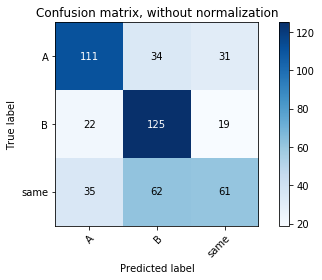

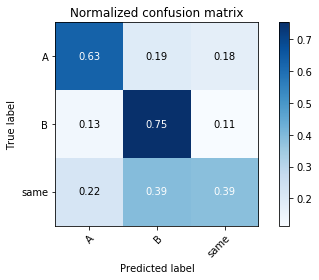

In [18]:
plot_confusion_matrix(Y_test, predicted, classes=MASS_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_test, predicted, classes=MASS_CLASS_COLS, normalize=True)

# FORCE TRAINING  (Humans achieve 61% +- 22%)

## Read dataset and preprocess it

In [6]:
all_trials = read_dataset("data/train_passive_trials.h5", first_n_trials=4000)
train_loader, val_loader, scaler = prepare_dataset(all_trials, FORCE_CLASS_COLS, BATCH_SIZE, NORMALISE_DATA, TEST_SIZE)

100%|██████████| 3500/3500 [00:02<00:00, 1176.38it/s]


In [7]:
Y = []
for x,y in train_loader:
    
    Y.extend(list(y))

counts = np.unique(Y, return_counts=True)[1]

In [8]:
print("Majority class: ", np.max(counts) / np.sum(counts))

Majority class:  0.33714285714285713


## Define model, loss and optimizer

In [9]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = len(BASIC_TRAINING_COLS)    # input dimension
hidden_dim = 20  # hidden layer dimension
n_layers = 3     # number of hidden layers
output_dim = 3   # output dimension
dropout = 0.5

model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim, dropout=dropout)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train model and plot loss and accuracy

In [10]:
model.train()
epoch_losses, epoch_accuracies, best_model = training_loop(model, optimizer, error, train_loader, val_loader, EPOCHS)

Train_loss (0.05)	 Train_acc (86.46)	 Val_acc (81.00): 100%|██████████| 50/50 [07:00<00:00,  8.36s/it]


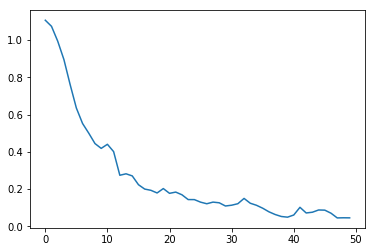

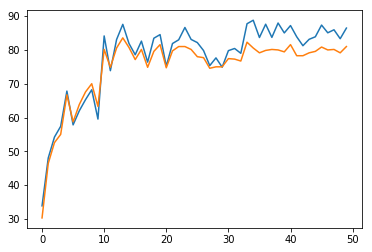

In [11]:
plt.plot(epoch_losses)
plt.show()
plt.plot(np.array(epoch_accuracies).T)
plt.show()

In [26]:
max(epoch_accuracies[1])

88.25

## Save model and scaler

In [13]:
torch.save(best_model.state_dict(), "models/passive_force_model.pt")

In [14]:
joblib.dump(scaler, "scalers/passive_force_scaler.sk")

['scalers/passive_force_scaler.sk']

## Load model and evaluate

In [15]:
scaler = joblib.load("scalers/passive_force_scaler.sk")

In [16]:
model = ComplexRNNModel(input_dim, hidden_dim, n_layers, output_dim)
model.load_state_dict(torch.load("models/passive_force_model.pt"))
model.eval()
model = model.cuda()

In [17]:
all_trials = read_dataset("data/test_passive_trials.h5")
test_loader = prepare_test_dataset(all_trials, FORCE_CLASS_COLS, scaler=scaler)

100%|██████████| 500/500 [00:00<00:00, 1162.25it/s]


In [18]:
accuracy, predicted = evaluate(model, test_loader, return_predicted=True)

In [19]:
print(accuracy)

78.2


In [20]:
predicted = [pred.cpu() for pred in predicted]
Y_test = np.concatenate([y.cpu().numpy() for x, y in test_loader])

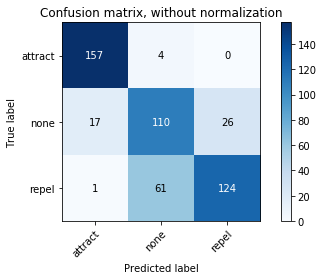

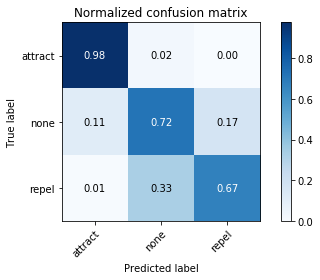

In [21]:
plot_confusion_matrix(Y_test, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_test, predicted, classes=FORCE_CLASS_COLS, normalize=True)